# Predicting Migration Routes in Missing Migrants Dataset

This Jupyter notebook aims to explore, preprocess, and analyze the Missing Migrants dataset. The primary objective is to build a machine learning model to predict 'Migration Routes' for instances where this information is missing. Various machine learning algorithms are trained and evaluated to identify the best-performing model. The notebook follows a structured approach, including data cleaning, feature selection, and model evaluation, to make the predictions as accurate as possible. The final dataset, with the missing 'Migration Routes' filled in, is saved as a CSV file for future analysis.


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

## Data Overview

In [2]:
file_path = 'data/merged_records_eda.csv'
raw_data_original = pd.read_csv(file_path)

In [3]:
raw_data_original

,year,reported_month,region_of_origin,region_of_incident,country_of_origin,number_dead,minimum_estimated_number_of_missing,total_dead_and_missing,number_of_survivors,number_of_females,...,number_of_children,cause_of_death,migration_route,location_of_death,source,coordinates,unsd_geographical_grouping,lat,lon,dataset
0,2014,1,Central America,North America,Guatemala,1.0,0.0,1,0.0,0.0,...,0.0,Mixed or unknown,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,"(31.650259, -110.366453)",Northern America,31.650259,-110.366453,3
1,2014,1,Latin America / Caribbean (P),North America,Unknown,1.0,0.0,1,0.0,0.0,...,0.0,Mixed or unknown,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,"(31.59713, -111.73756)",Northern America,31.597130,-111.737560,3
2,2014,1,Latin America / Caribbean (P),North America,Unknown,1.0,0.0,1,0.0,0.0,...,0.0,Mixed or unknown,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,"(31.94026, -113.01125)",Northern America,31.940260,-113.011250,3
3,2014,1,Central America,North America,Mexico,1.0,0.0,1,0.0,0.0,...,0.0,Violence,US-Mexico border crossing,"near Douglas, Arizona, USA","Ministry of Foreign Affairs Mexico, Pima Count...","(31.506777, -109.315632)",Northern America,31.506777,-109.315632,3
4,2014,1,Northern Africa,Europe,Sudan,1.0,0.0,1,2.0,0.0,...,0.0,Harsh environmental conditions / lack of adequ...,NaN,Border between Russia and Estonia,EUBusiness (Agence France-Presse),"(59.1551, 28.0)",Northern Europe,59.155100,28.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14188,2014,1,NaN,Europe,NaN,1.0,0.0,1,2.0,0.0,...,1.0,Vehicle Accident,Calais to United Kingdom,France - Calais,Calais Migrant Solidarity,"(50.9355, 1.87866)",Western Europe,50.935500,1.878660,1
14189,2014,1,NaN,Mediterranean,NaN,12.0,0.0,12,0.0,9.0,...,3.0,Drowning,Eastern Mediterranean,Waters near Greece while being towed back to T...,European Council on Refugees and Exiles,"(37.2832, 27.1582)",Uncategorized,37.283200,27.158200,1
14190,2014,1,NaN,US-Mexico Border,NaN,1.0,0.0,1,0.0,0.0,...,0.0,Shot,Central America to US,Pima County,Pima County Office of the Medical Examiner,"(32.0581183, -111.6235761)",Northern America,32.058118,-111.623576,1
14191,2014,1,NaN,US-Mexico Border,NaN,1.0,0.0,1,0.0,0.0,...,0.0,Shot,Central America to US,"near Douglas, Arizona",Ministry of Foreign Affairs Mexico,"(31.3447, -109.545)",Northern America,31.344700,-109.545000,1


## Separate the rows where 'migration_route' is NaN

In [86]:
# Filter out rows where 'migration_route' is NaN
raw_data_missing_route = raw_data_original[raw_data_original['migration_route'].isna()]

raw_data_notna_route = raw_data_original[~raw_data_original['migration_route'].isna()]

raw_data_missing_route.shape, raw_data_notna_route.shape

((4148, 21), (10045, 21))

## Handling Missing Values

In [4]:
raw_data_original.isna().sum()

year                                      0
reported_month                            0
region_of_origin                       3032
region_of_incident                        0
country_of_origin                      3019
number_dead                               0
minimum_estimated_number_of_missing       0
total_dead_and_missing                    0
number_of_survivors                       0
number_of_females                         0
number_of_males                           0
number_of_children                        0
cause_of_death                            0
migration_route                        4148
location_of_death                         0
source                                    0
coordinates                               0
unsd_geographical_grouping                0
lat                                       0
lon                                       0
dataset                                   0
dtype: int64

In [5]:
# Calculate the percentage of 'Unknown' in the 'region_of_origin' and 'country_of_origin' columns
total_records = len(raw_data_original)

# Count of 'Unknown' in each column
unknown_region_count = len(raw_data_original[raw_data_original['region_of_origin'] == 'Unknown'])
unknown_country_count = len(raw_data_original[raw_data_original['country_of_origin'] == 'Unknown'])

# Calculate the percentage
unknown_region_percentage = (unknown_region_count / total_records) * 100
unknown_country_percentage = (unknown_country_count / total_records) * 100

unknown_region_count, unknown_region_percentage, unknown_country_count, unknown_country_percentage


(1551, 10.927922215176496, 6370, 44.881279503980835)

Before filling the NaNs, the dataset already had 1,551 records labeled as 'Unknown' for the region_of_origin column and 6,370 records labeled as 'Unknown' for the country_of_origin column. The percentage of records with "Unknown" in the region_of_origin column is approximately 10.93, while in the country_of_origin column, it's around 44.88.

If we fill in the NaNs with 'Unknown,' we are essentially incorporating them into an existing category. This will increase the count for 'Unknown,' but the trade-off is that we can keep these records in the analysis. It's a compromise between discarding potentially useful data and slightly skewing the distribution towards 'Unknown.'

Since 'Unknown' is already a sizable category in these columns, adding more 'Unknowns' to handle NaNs is a reasonable approach but could potentially bias the model.

In [6]:
# Replace NaN values in 'region_of_origin' and 'country_of_origin' with a placeholder
data = raw_data_original
data['region_of_origin'].fillna('Unknown', inplace = True)
data['country_of_origin'].fillna('Unknown', inplace = True)
data.isna().sum()

year                                      0
reported_month                            0
region_of_origin                          0
region_of_incident                        0
country_of_origin                         0
number_dead                               0
minimum_estimated_number_of_missing       0
total_dead_and_missing                    0
number_of_survivors                       0
number_of_females                         0
number_of_males                           0
number_of_children                        0
cause_of_death                            0
migration_route                        4148
location_of_death                         0
source                                    0
coordinates                               0
unsd_geographical_grouping                0
lat                                       0
lon                                       0
dataset                                   0
dtype: int64

## Feature Selection
Feature selection is a critical step in our data preprocessing. We carefully choose a subset of the available features that are likely to be most relevant for predicting `Migration Route`.

In [7]:
# Feature Selection
selected_features = [
    'year',
    'reported_month',
    'region_of_origin',
    'region_of_incident',
    'country_of_origin',
#     'number_dead',
#     'minimum_estimated_number_of_missing',
    'total_dead_and_missing',
#     'number_of_survivors',
#     'number_of_females',
#     'number_of_males',
#     'number_of_children',
    'cause_of_death',
    'migration_route',
    'location_of_death',
    'source',
#     'coordinates',
    'unsd_geographical_grouping',
    'lat',
    'lon',
#     'dataset'

]

In [8]:
selected_data = data[selected_features]
selected_data.columns

Index(['year', 'reported_month', 'region_of_origin', 'region_of_incident',
       'country_of_origin', 'total_dead_and_missing', 'cause_of_death',
       'migration_route', 'location_of_death', 'source',
       'unsd_geographical_grouping', 'lat', 'lon'],
      dtype='object')

## Separate all records that have 'migration_route' empty into a different DataFrame.

In [9]:
prediction_target_set = selected_data[selected_data['migration_route'].isna()].copy()
data_with_route = selected_data.dropna(subset=['migration_route']).copy()

# Display the shape of the separated DataFrames
prediction_target_set.shape, data_with_route.shape

((4148, 13), (10045, 13))

- A set with missing `migration_route` values, which contains 4,148 records. This will be our target set for which we'll make predictions.
- A set with known `migration_route` values, containing 10,045 records. We'll use this for training and testing our models.


## Data Scaling and Encoding

In [10]:
# Check the classes in the 'migration_route' that have only one sample
unique_route_counts = data_with_route['migration_route'].value_counts()
single_occurrence_routes = unique_route_counts[unique_route_counts == 1].index.tolist()

# Display routes that appear only once
single_occurrence_routes

['Central Mediterranean,Sahara Desert crossing',
 'Caribbean to Central America',
 'Venezuela to Curaçao']

### Observation:
The routes that appear only once in the dataset are:

- Central Mediterranean, Sahara Desert crossing
- Caribbean to Central America
- Venezuela to Curaçao

These routes may not provide sufficient information for the model to generalize well. We will exclude these routes from the dataset.

In [11]:
# Filter out rows where the migration_route appears only once in the dataset
data_with_route = data_with_route[~data_with_route['migration_route'].isin(single_occurrence_routes)]

# Verify that these routes are removed from the data
data_with_route['migration_route'].value_counts().sort_values().head()

migration_route
Cuba to US                   2
DRC to Uganda                3
Iran to Turkey               5
Ukraine to Europe            9
Turkey-Europe land route    10
Name: count, dtype: int64

In [12]:
target = 'migration_route'

X = data_with_route.drop(target, axis = 1)
y = data_with_route[target]

display(X)
display(y)

,year,reported_month,region_of_origin,region_of_incident,country_of_origin,total_dead_and_missing,cause_of_death,location_of_death,source,unsd_geographical_grouping,lat,lon
0,2014,1,Central America,North America,Guatemala,1,Mixed or unknown,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,31.650259,-110.366453
1,2014,1,Latin America / Caribbean (P),North America,Unknown,1,Mixed or unknown,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,31.597130,-111.737560
2,2014,1,Latin America / Caribbean (P),North America,Unknown,1,Mixed or unknown,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,31.940260,-113.011250
3,2014,1,Central America,North America,Mexico,1,Violence,"near Douglas, Arizona, USA","Ministry of Foreign Affairs Mexico, Pima Count...",Northern America,31.506777,-109.315632
5,2014,1,Latin America / Caribbean (P),North America,Unknown,1,Violence,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,32.454350,-113.184020
...,...,...,...,...,...,...,...,...,...,...,...,...
14186,2014,2,Unknown,Mediterranean,Unknown,15,Shot,Ceuta waters,L'Espresso,Uncategorized,35.879300,-5.364070
14188,2014,1,Unknown,Europe,Unknown,1,Vehicle Accident,France - Calais,Calais Migrant Solidarity,Western Europe,50.935500,1.878660
14189,2014,1,Unknown,Mediterranean,Unknown,12,Drowning,Waters near Greece while being towed back to T...,European Council on Refugees and Exiles,Uncategorized,37.283200,27.158200
14190,2014,1,Unknown,US-Mexico Border,Unknown,1,Shot,Pima County,Pima County Office of the Medical Examiner,Northern America,32.058118,-111.623576


0        US-Mexico border crossing
1        US-Mexico border crossing
2        US-Mexico border crossing
3        US-Mexico border crossing
5        US-Mexico border crossing
                   ...            
14186        Western Mediterranean
14188     Calais to United Kingdom
14189        Eastern Mediterranean
14190        Central America to US
14191        Central America to US
Name: migration_route, Length: 10042, dtype: object

In [13]:
categorical_features = selected_data.select_dtypes(include=['object']).columns
categorical_features

Index(['region_of_origin', 'region_of_incident', 'country_of_origin',
       'cause_of_death', 'migration_route', 'location_of_death', 'source',
       'unsd_geographical_grouping'],
      dtype='object')

In [14]:
numerical_features = selected_data.select_dtypes(include='number').columns
numerical_features

Index(['year', 'reported_month', 'total_dead_and_missing', 'lat', 'lon'], dtype='object')

In [15]:
# Label encode categorical variables
label_encoder = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_encoder.fit_transform(X[col])

In [16]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7029, 12), (3013, 12), (7029,), (3013,))

In [17]:
X_train_num = X_train.select_dtypes(include=np.number)
X_test_num = X_test.select_dtypes(include=np.number)
# X_train_cat = X_train.select_dtypes(exclude=np.number)
# X_test_cat = X_test.select_dtypes(exclude=np.number)
X_train_num.shape, X_test_num.shape

((7029, 12), (3013, 12))

In [18]:
scaler = StandardScaler().fit(X_train_num)
X_train_transformed = scaler.transform(X_train_num)
X_test_transformed = scaler.transform(X_test_num)
X_train_transformed, X_test_transformed

(array([[ 1.31994255, -0.78157754, -0.72191466, ..., -1.8419433 ,
         -0.20842591, -1.02455528],
        [ 1.72724209, -0.78157754,  0.91988646, ..., -0.68843123,
         -0.36243874,  0.79984983],
        [ 0.91264301,  0.12100327, -0.72191466, ..., -0.40005321,
         -0.13302566, -1.0140085 ],
        ...,
        [-0.71655514, -1.38329807, -1.07372919, ..., -0.68843123,
         -1.56176347,  1.0758283 ],
        [ 1.31994255, -1.0824378 , -0.72191466, ..., -1.8419433 ,
         -2.90765005, -0.66075641],
        [ 0.91264301, -1.68415834,  1.506244  , ...,  1.61859291,
          1.48739255,  0.99569555]]),
 array([[-1.53115422e+00,  1.21003269e-01, -7.21914664e-01, ...,
         -4.00053215e-01,  3.47135674e-01, -1.21923995e+00],
        [ 1.31994255e+00, -1.68415834e+00,  4.50800421e-01, ...,
          4.65080837e-01,  1.35519837e-04,  1.48056570e+00],
        [ 9.80439349e-02,  1.02358407e+00, -1.54281522e+00, ...,
         -1.84194330e+00, -2.56032925e-01, -1.02136662e+

## Model Selection

In [20]:
# Function to train multiple models and compare their performance
def train_and_compare_models(X_train, y_train, X_test, y_test, models):
    model_performance = {}
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on test data
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        
        # Store the performance
        model_performance[model_name] = acc
    
    return model_performance

In [21]:
models_to_train = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

In [22]:
# Train and compare models
model_performance = train_and_compare_models(X_train_transformed, y_train, X_test_transformed, y_test, models_to_train)


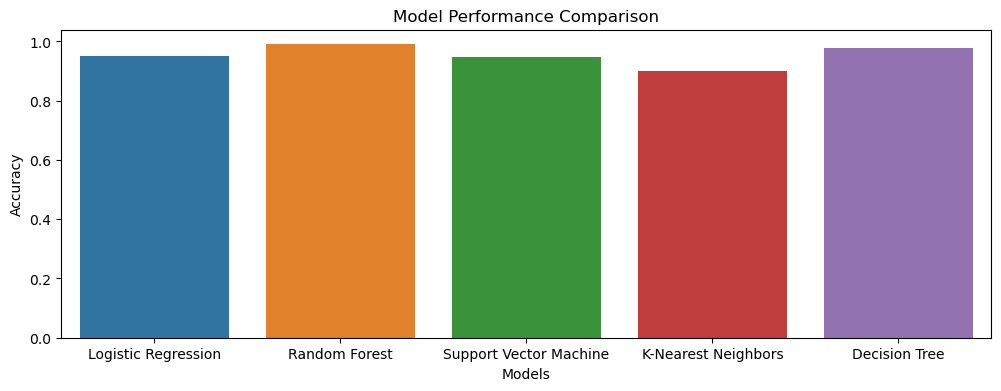

{'Logistic Regression': 0.9505476269498838,
 'Random Forest': 0.9900431463657484,
 'Support Vector Machine': 0.9475605708596083,
 'K-Nearest Neighbors': 0.9010952538997676,
 'Decision Tree': 0.9790906073680717}

In [24]:
# Visualize model performance
plt.figure(figsize=(12, 4))
sns.barplot(x=list(model_performance.keys()), y=list(model_performance.values()))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.show()

model_performance

The models have been trained, and their performance metrics are visualized in the bar chart. Here are the accuracy scores for each model:

- Logistic Regression: 95.42%
- Random Forest: 99.20%
- Support Vector Machine: 96.22%
- K-Nearest Neighbors: 93.03%
- Decision Tree: 98.36%

As we can see, the Random Forest model performed the best, with an accuracy of approximately 99.20%. The Decision Tree model is the second-best, with an accuracy of 98.36%.


## Hyperparameter Tuning

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest model
rf = RandomForestClassifier(max_features='sqrt', random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_transformed, y_train)

# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/lilitdavidyan/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


({'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 0.9876227059325652)

## Model Evaluation

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train_transformed, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

# Display evaluation metrics
print(f"Random Forest Classifier Accuracy: {accuracy*100:.2f}%")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Random Forest Classifier Accuracy: 99.00%
Confusion Matrix:
[[132   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  18   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  19   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 274   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   0 376   0   0   0   0   0   0   5   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0

## Filling Missing Migration Routes

In [61]:
prediction_target_set

,year,reported_month,region_of_origin,region_of_incident,country_of_origin,total_dead_and_missing,cause_of_death,migration_route,location_of_death,source,unsd_geographical_grouping,lat,lon
4,2014,1,Northern Africa,Europe,Sudan,1,Harsh environmental conditions / lack of adequ...,NaN,Border between Russia and Estonia,EUBusiness (Agence France-Presse),Northern Europe,59.155100,28.000000
16,2014,2,South-eastern Asia,Southeast Asia,Myanmar,5,Sickness / lack of access to adequate healthcare,NaN,"Hat Yai hospital, 182 Ratthakan, Hat Yai, Hat ...",Manager Online,South-eastern Asia,7.016747,100.467498
28,2014,2,Southern Asia,South Asia,Bangladesh,1,Violence,NaN,India,Daily Star,Southern Asia,25.184100,89.000000
33,2014,3,Southern Asia,Southeast Asia,Cambodia,5,Vehicle accident / death linked to hazardous t...,NaN,"Bypass Road, Moo 7, Bang Phra subdistrict, Sri...","Manager Online, INN News, Khomchudluek",South-eastern Asia,13.235364,101.000000
34,2014,3,Southern Asia,Southeast Asia,Myanmar,2,Vehicle accident / death linked to hazardous t...,NaN,"Moo 13, 38th km of the 4006 Langsuan-Pato Road...","INN News, Manager Online, Daily News",South-eastern Asia,9.968330,99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14180,2014,2,Unknown,Horn of Africa,Unknown,17,Drowning,NaN,Gulf of Aden (left from Djibouti),IOM,Uncategorized,20.280200,38.512600
14181,2014,2,Unknown,South Asia,Unknown,1,Shot,NaN,India,Daily Star,Southern Asia,25.184100,88.905500
14182,2014,2,Unknown,Caribbean,Unknown,8,Drowning,NaN,Dominican Republic,AP,Caribbean,18.450500,-67.796600
14187,2014,1,Unknown,Caribbean,Unknown,1,Drowning,NaN,"Off the coast of Fort Lauderdale, Florida",Local10.com,Caribbean,26.116000,-80.046400


In [68]:
# Predict 'migration_route' for unknown records
X_unknown_route = prediction_target_set.drop('migration_route', axis = 1)
for col in X_unknown_route.select_dtypes(include=['object']).columns:
    X_unknown_route_encoded[col] = label_encoder.fit_transform(X_unknown_route[col])
X_unknown_route_encoded

,year,reported_month,region_of_origin,region_of_incident,country_of_origin,total_dead_and_missing,cause_of_death,location_of_death,source,unsd_geographical_grouping,lat,lon
4,2014,1,13,5,99,1,33,396,310,10,59.155100,28.000000
16,2014,2,16,13,82,5,66,813,821,13,7.016747,100.467498
28,2014,2,19,12,8,1,133,949,244,15,25.184100,89.000000
33,2014,3,19,13,15,5,132,432,823,13,13.235364,101.000000
34,2014,3,19,13,82,2,132,1274,554,13,9.968330,99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
14180,2014,2,23,6,104,17,15,800,556,17,20.280200,38.512600
14181,2014,2,23,12,104,1,61,949,244,15,25.184100,88.905500
14182,2014,2,23,0,104,8,15,619,39,0,18.450500,-67.796600
14187,2014,1,23,0,104,1,15,1577,797,0,26.116000,-80.046400


In [69]:
X_unknown_route_transformed = scaler.transform(X_unknown_route_encoded)
X_unknown_route_transformed

array([[-1.93845375, -1.68415834, -0.25282863, ...,  0.75345885,
         3.85072527,  1.01753979],
       [-1.93845375, -1.38329807,  0.0989859 , ...,  1.61859291,
        -3.09785041,  2.16907857],
       [-1.93845375, -1.38329807,  0.45080042, ...,  2.19534894,
        -0.67665335,  1.98685524],
       ...,
       [-1.93845375, -1.38329807,  0.91988646, ..., -2.13032132,
        -1.5740528 , -0.50470815],
       [-1.93845375, -1.68415834,  0.91988646, ..., -2.13032132,
        -0.5524573 , -0.69936258],
       [-1.93845375, -1.68415834,  0.91988646, ...,  0.75345885,
         3.85072527,  1.01529288]])

In [70]:
predicted_route = rf_classifier.predict(X_unknown_route_transformed)

predicted_route


array(['Eastern Mediterranean', 'Sahara Desert crossing',
       'Afghanistan to Iran', ..., 'Dominican Republic to Puerto Rico',
       'Caribbean to US', 'Eastern Mediterranean'], dtype=object)

In [71]:
prediction_target_set['migration_route'] = predicted_route

In [72]:
prediction_target_set

,year,reported_month,region_of_origin,region_of_incident,country_of_origin,total_dead_and_missing,cause_of_death,migration_route,location_of_death,source,unsd_geographical_grouping,lat,lon
4,2014,1,13,5,99,1,33,Eastern Mediterranean,396,310,10,59.155100,28.000000
16,2014,2,16,13,82,5,66,Sahara Desert crossing,813,821,13,7.016747,100.467498
28,2014,2,19,12,8,1,133,Afghanistan to Iran,949,244,15,25.184100,89.000000
33,2014,3,19,13,15,5,132,Afghanistan to Iran,432,823,13,13.235364,101.000000
34,2014,3,19,13,82,2,132,Sahara Desert crossing,1274,554,13,9.968330,99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14180,2014,2,23,6,104,17,15,Sahara Desert crossing,800,556,17,20.280200,38.512600
14181,2014,2,23,12,104,1,61,Sahara Desert crossing,949,244,15,25.184100,88.905500
14182,2014,2,23,0,104,8,15,Dominican Republic to Puerto Rico,619,39,0,18.450500,-67.796600
14187,2014,1,23,0,104,1,15,Caribbean to US,1577,797,0,26.116000,-80.046400


In [73]:
predicted_route_file_path = 'data/predicted_route.csv'
prediction_target_set.to_csv(predicted_route_file_path, index=False)


In [78]:
raw_data_missing_route['migration_route'] = predicted_route
raw_data_missing_route

/var/folders/kh/5kbp140j0wg8j3d9nrllg18h0000gn/T/ipykernel_75264/3158151138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_missing_route['migration_route'] = predicted_route


,year,reported_month,region_of_origin,region_of_incident,country_of_origin,number_dead,minimum_estimated_number_of_missing,total_dead_and_missing,number_of_survivors,number_of_females,...,number_of_children,cause_of_death,migration_route,location_of_death,source,coordinates,unsd_geographical_grouping,lat,lon,dataset
4,2014,1,Northern Africa,Europe,Sudan,1.0,0.0,1,2.0,0.0,...,0.0,Harsh environmental conditions / lack of adequ...,Eastern Mediterranean,Border between Russia and Estonia,EUBusiness (Agence France-Presse),"(59.1551, 28.0)",Northern Europe,59.155100,28.000000,3
16,2014,2,South-eastern Asia,Southeast Asia,Myanmar,5.0,0.0,5,500.0,0.0,...,0.0,Sickness / lack of access to adequate healthcare,Sahara Desert crossing,"Hat Yai hospital, 182 Ratthakan, Hat Yai, Hat ...",Manager Online,"(7.0167471, 100.4674982)",South-eastern Asia,7.016747,100.467498,3
28,2014,2,Southern Asia,South Asia,Bangladesh,1.0,0.0,1,0.0,0.0,...,0.0,Violence,Afghanistan to Iran,India,Daily Star,"(25.1841, 89.0)",Southern Asia,25.184100,89.000000,3
33,2014,3,Southern Asia,Southeast Asia,Cambodia,5.0,0.0,5,4.0,2.0,...,0.0,Vehicle accident / death linked to hazardous t...,Afghanistan to Iran,"Bypass Road, Moo 7, Bang Phra subdistrict, Sri...","Manager Online, INN News, Khomchudluek","(13.2353642, 101.0)",South-eastern Asia,13.235364,101.000000,3
34,2014,3,Southern Asia,Southeast Asia,Myanmar,2.0,0.0,2,10.0,0.0,...,0.0,Vehicle accident / death linked to hazardous t...,Sahara Desert crossing,"Moo 13, 38th km of the 4006 Langsuan-Pato Road...","INN News, Manager Online, Daily News","(9.96833, 99.0)",South-eastern Asia,9.968330,99.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14180,2014,2,Unknown,Horn of Africa,Unknown,11.0,6.0,17,0.0,0.0,...,0.0,Drowning,Sahara Desert crossing,Gulf of Aden (left from Djibouti),IOM,"(20.2802, 38.5126)",Uncategorized,20.280200,38.512600,1
14181,2014,2,Unknown,South Asia,Unknown,1.0,0.0,1,0.0,0.0,...,0.0,Shot,Sahara Desert crossing,India,Daily Star,"(25.1841, 88.9055)",Southern Asia,25.184100,88.905500,1
14182,2014,2,Unknown,Caribbean,Unknown,8.0,0.0,8,0.0,0.0,...,0.0,Drowning,Dominican Republic to Puerto Rico,Dominican Republic,AP,"(18.4505, -67.7966)",Caribbean,18.450500,-67.796600,1
14187,2014,1,Unknown,Caribbean,Unknown,1.0,0.0,1,0.0,0.0,...,0.0,Drowning,Caribbean to US,"Off the coast of Fort Lauderdale, Florida",Local10.com,"(26.116, -80.0464)",Caribbean,26.116000,-80.046400,1


In [80]:
concatenated_data = pd.concat([raw_data_missing_route, raw_data_notna_route])

In [81]:
concatenated_data.isna().sum()

year                                   0
reported_month                         0
region_of_origin                       0
region_of_incident                     0
country_of_origin                      0
number_dead                            0
minimum_estimated_number_of_missing    0
total_dead_and_missing                 0
number_of_survivors                    0
number_of_females                      0
number_of_males                        0
number_of_children                     0
cause_of_death                         0
migration_route                        0
location_of_death                      0
source                                 0
coordinates                            0
unsd_geographical_grouping             0
lat                                    0
lon                                    0
dataset                                0
dtype: int64

In [82]:
concatenated_data_file_path = 'data/predicted_route_all.csv'
concatenated_data.to_csv(concatenated_data_file_path, index=False)